In [13]:
!git clone https://github.com/pablogiaccaglia/segmentation_pytorch
!pip install git+https://github.com/pablogiaccaglia/segmentation_pytorch
%cd /content/segmentation_pytorch/

Cloning into 'segmentation_pytorch'...
remote: Enumerating objects: 134, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 134 (delta 10), reused 14 (delta 7), pack-reused 113
Receiving objects: 100% (134/134), 146.16 MiB | 31.17 MiB/s, done.
Resolving deltas: 100% (64/64), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/pablogiaccaglia/segmentation_pytorch to /tmp/pip-req-build-4yd9wchf
  Running command git clone -q https://github.com/pablogiaccaglia/segmentation_pytorch /tmp/pip-req-build-4yd9wchf
ERROR: File "setup.py" not found for legacy project git+https://github.com/pablogiaccaglia/segmentation_pytorch.
/content/segmentation_pytorch


In [14]:
#@title **Google Drive connection**
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
import os
import sys
import cv2
import time
import timeit
import random
import pathlib
import logging
import numpy as np
import albumentations
from tqdm import tqdm
from functools import partial
from typing import Tuple, List
import sys
!{sys.executable} -m pip install einops
!{sys.executable} -m pip install tensorflow_addons
!{sys.executable} -m pip install timm
!{sys.executable} -m pip install mmvc
!{sys.executable} -m pip install tensorboardX
!{sys.executable} -m pip install torchviz
!{sys.executable} -m pip install yacs
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from mmcv.runner import build_optimizer
from tensorboardX import SummaryWriter
import matplotlib.pyplot as plt
from torchviz import make_dot
from models.segformer import Segformer

#%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)

from utils.label_utils import get_labels
from utils.lr_schedule import PolyLrUpdater
from utils.modelsummary import get_model_summary
from utils.runners import train, validate, testval
from utils.data_utils import label_mapping, SegmentationDataset, display, cityscapes_label_to_rgb
from utils.train_utils import AverageMeter, CrossEntropy, get_confusion_matrix, create_logger
from utils.transformations import (ComposeDouble, FunctionWrapperDouble, normalize, re_normalize,
                                   random_crop, random_resize, random_brightness, AlbuSeg2d, scale_aug)

from configs.segformer_config import config as cfg

labels = get_labels()
id2label =      { label.id      : label for label in labels }
trainid2label = { label.trainId : label for label in labels }

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement mmvc (from versions: none)
ERROR: No matching distribution found for mmvc
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [16]:
#@title **Data Loader**

def loadNumpyArrays(folderPath: str, arr, max, channels_first = False) -> np.ndarray:
    i = 0

    entries = os.listdir(folderPath)
    entries.sort()
    #print(entries)
    for entry in entries:

      if i==len(arr):
        break

      if ".DS_Store" not in str(entry) and "(1).npy" not in str(entry):

        l = np.load(folderPath + entry)
        #print(l.shape)
        
        if "IMG" in folderPath:
            l = np.dstack([l,l,l])
        else:
            # l = np.expand_dims(l, axis = -1)
            pass

        if "IMG" in folderPath:
          # l = tf.keras.applications.vgg16.preprocess_input(l)
          pass
        
        arr[i] = l
        i = i + 1
        if i==max:
          break

    if channels_first:
        arr = np.transpose(arr, (0, 3, 1, 2))
    
    return arr

def getDatasetArraysForNet() -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    trainingImgDir = "/content/drive/MyDrive/Arrays-cbis/Dataset-split-arrays/Training-Final-IMG-Arrayss/"
    trainingMaskDir = "/content/drive/MyDrive/Arrays-cbis/Dataset-split-arrays/Training-Final-MSK-Arrays/"
    validationImgDir = "/content/drive/MyDrive/Arrays-cbis/Dataset-split-arrays/Validation-Final-IMG-Arrays/"
    validationMaskDir = "/content/drive/MyDrive/Arrays-cbis/Dataset-split-arrays/Validation-Final-MSK-Arrays/"
    testingImgDir = "/content/drive/MyDrive/Arrays-cbis/Dataset-split-arrays/Testing-Final-IMG-Arrays/"
    testingMaskDir = "/content/drive/MyDrive/Arrays-cbis/Dataset-split-arrays/Testing-Final-MSK-Arrays/"

    h = w = 256
    batch1 = 20
    batch2  = 5
    channels_first = True

    dim1 = (batch1, h, w, 3)
    dim2 = (batch1, h, w, 1)
    dim3 = (batch2, h, w, 3)
    dim4 = (batch1, h, w, 1)


    return loadNumpyArrays(folderPath = trainingImgDir, arr = np.ndarray(dim1, dtype = 'float32'), max = 20, channels_first = channels_first), \
           loadNumpyArrays(folderPath = trainingMaskDir, arr = np.ndarray(dim2, dtype = 'uint8'), max = 20, channels_first = channels_first), \
           loadNumpyArrays(folderPath = validationImgDir, arr = np.ndarray(dim1, dtype = 'float32'), max = 20, channels_first = channels_first), \
           loadNumpyArrays( folderPath = validationMaskDir, arr = np.ndarray(dim2, dtype = 'uint8'), max = 20, channels_first = channels_first), \
           loadNumpyArrays(folderPath = testingImgDir, arr = np.ndarray(dim3, dtype = 'float32'), max = 20), loadNumpyArrays(folderPath = testingMaskDir, arr = np.ndarray(dim4, dtype = 'uint8'), max = 5, channels_first = channels_first)

In [17]:
imgs_train, imgs_mask_train, imgs_val, imgs_mask_val, imgs_test, imgs_mask_test_gt = getDatasetArraysForNet()

def getTensorDataset(x, y):
  return TensorDataset(torch.Tensor(x), torch.Tensor(y))

train_dataloader = DataLoader(
    dataset = getTensorDataset(imgs_train, imgs_mask_train), 
    batch_size = cfg.TRAIN.ADJ_BATCH_SIZE, 
    shuffle = True,
    drop_last = True,
    num_workers = 4,
    prefetch_factor = 8,
    pin_memory=True
    
)
valid_dataloader = DataLoader(
    dataset =getTensorDataset(imgs_val, imgs_mask_val), 
    batch_size = cfg.TRAIN.ADJ_BATCH_SIZE, 
    shuffle = True,
    drop_last = True,
    num_workers = 4,
    prefetch_factor = 8,
    pin_memory=True
    
)

x, y = next(iter(train_dataloader))
xv, yv = next(iter(valid_dataloader))

x_min, x_max = x.min(), x.max()
print('x.shape: {}, x.type: {}, [min(x), max(x)]: [{:.3f}, {:.3f}]'.format(x.numpy().shape, x.dtype, x_min, x_max))
print('y.shape: {}, y.type: {} \ny unique: {}'.format(y.numpy().shape, y.dtype, np.unique(y.numpy()).tolist()))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


x.shape: (2, 3, 256, 256), x.type: torch.float32, [min(x), max(x)]: [1.000, 248.000]
y.shape: (2, 1, 256, 256), y.type: torch.float32 
y unique: [0.0, 1.0]


In [29]:
def mammograms_label_to_rgb(mask):
    h = mask.shape[1]
    w = mask.shape[2]
    print(mask.shape)
    mask_rgb = np.zeros((h, w, 3), dtype=np.uint8)
    for key, val in trainid2label.items():
        indices = mask == key
        mask_rgb[indices.squeeze()] = val.color 
    return mask_rgb


def display_blend(display_list):
    plt.figure(figsize=(10, 10), dpi=200)
    for i in range(len(display_list)):
        blend = cv2.addWeighted(display_list[i][0], 0.8, display_list[i][1], 0.6, 0)
        plt.subplot(1, len(display_list), i+1)
        plt.imshow(blend)
        plt.axis('off')
    plt.tight_layout()
    plt.show()


In [21]:
print(labels)

[Label(name='unlabeled', id=0, trainId=0, category='void', categoryId=0, hasInstances=False, ignoreInEval=True, color=(0, 0, 0)), Label(name='cancer', id=1, trainId=1, category='human', categoryId=6, hasInstances=True, ignoreInEval=False, color=(220, 20, 60))]


torch.Size([1, 256, 256])
torch.Size([1, 256, 256])


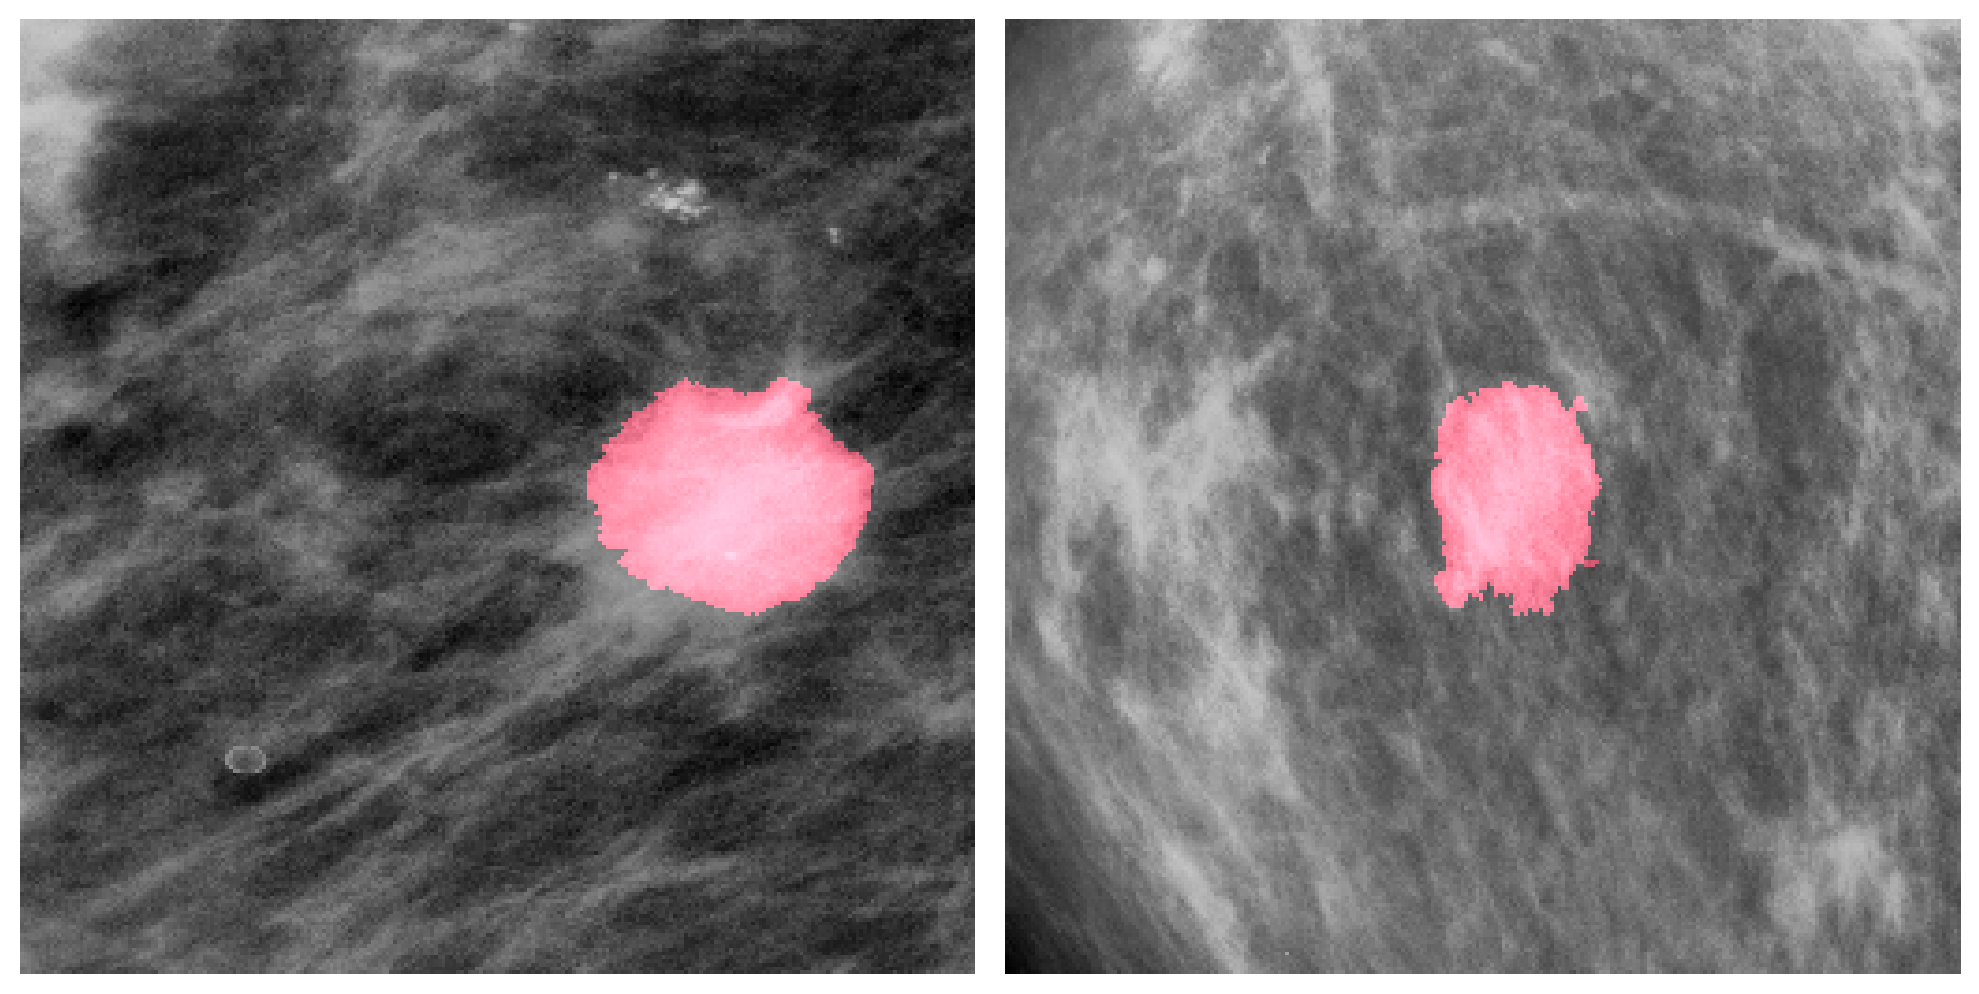

In [30]:
idx = 1
display_blend([
    [re_normalize(x[idx].permute(1,2,0).numpy()), mammograms_label_to_rgb(y[idx])],
    [re_normalize(xv[idx].permute(1,2,0).numpy()), mammograms_label_to_rgb(yv[idx])]
])

In [32]:
SEG_CFG = cfg.MODEL.B1

In [39]:

model = Segformer(
    pretrained = None, # CHECK THIS TO LOAD PRETRAINED MODEL
    img_size = cfg.DATASET.CROP_SIZE[0], 
    patch_size = cfg.MODEL.PATCH_SIZE, 
    embed_dims = SEG_CFG.CHANNEL_DIMS, 
    num_heads = SEG_CFG.NUM_HEADS, 
    mlp_ratios = SEG_CFG.MLP_RATIOS,
    qkv_bias = SEG_CFG.QKV_BIAS, 
    depths = SEG_CFG.DEPTHS, 
    sr_ratios = SEG_CFG.SR_RATIOS,
    drop_rate = SEG_CFG.DROP_RATE, 
    drop_path_rate = SEG_CFG.DROP_PATH_RATE,
    decoder_dim = SEG_CFG.DECODER_DIM,
    norm_layer = partial(nn.LayerNorm, eps=1e-6), 
).to(device)

In [38]:
criterion = CrossEntropy(
    ignore_label=cfg.DATASET.IGNORE_LABEL, 
    weight= torch.Tensor([1,1]) # CHANGE THIS!!
).to(device)


optimizer_cfg = dict(
    type=cfg.TRAIN.OPTIMIZER, 
    lr=cfg.TRAIN.BASE_LR,  
    weight_decay=cfg.TRAIN.WD,
    paramwise_cfg=dict(
        custom_keys={
            'pos_block': dict(decay_mult=0.), 
            'norm': dict(decay_mult=0.),
            'head': dict(lr_mult=10.)
        }
))

optimizer = build_optimizer(model, optimizer_cfg)

lr_scheduler = PolyLrUpdater(
    optimizer = optimizer,
    power = cfg.TRAIN.POWER,
    min_lr = cfg.TRAIN.MIN_LR,
    max_iters = cfg.TRAIN.DECAY_STEPS,
    epoch_len = len(train_dataloader),
    warmup = cfg.TRAIN.WARMUP,
    warmup_iters = cfg.TRAIN.WARMUP_ITERS,
    warmup_ratio = cfg.TRAIN.WARMUP_RATIO,
    by_epoch = cfg.TRAIN.BY_EPOCH,
)

In [ ]:
details = get_model_summary(model, x.cuda(), verbose=False)
print(details)

In [ ]:
def train(
    cfg, 
    dataloader, 
    model, 
    loss_fn, 
    optimizer, 
    lr_scheduler, 
    scaler, 
    writer_dict,
    epoch, 
):
    model.train()
    
    ave_loss = AverageMeter()
    steps_tot = epoch*len(dataloader) 
    writer = writer_dict['writer']
    global_steps = writer_dict['train_global_steps']
    
    for step, batch in enumerate(dataloader):
        X, y, _, _ = batch
        X, y = X.cuda(), y.long().cuda() 
        
        # Compute prediction and loss
        with torch.cuda.amp.autocast():
            pred = model(X.contiguous())
            pred = F.interpolate(pred, size = cfg.DATASET.CROP_SIZE, mode = 'bilinear', align_corners = False)
            losses = loss_fn(pred, y)
        loss = losses.mean()
        
        # Normalize loss to account for batch accumulation
        loss = loss / cfg.TRAIN.ACCUM_STEPS
            
        # Backward pass
        scaler.scale(loss).backward()
        
        # Weight update
        if ((step + 1) % cfg.TRAIN.ACCUM_STEPS == 0) or (step + 1 == len(dataloader)):
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

            # update average loss
            ave_loss.update(loss.item())

            # update learning schedule
            lr_scheduler.before_train_iter()
            lr = lr_scheduler.get_lr(int(steps_tot+step), cfg.TRAIN.BASE_LR)
        
        
    writer.add_scalar('train_loss', ave_loss.average(), global_steps)
    writer_dict['train_global_steps'] = global_steps + 1
    
    
def validate(
    cfg, 
    dataloader, 
    model, 
    loss_fn, 
    writer_dict
):
    model.eval()
    
    ave_loss = AverageMeter()
    iter_steps = len(dataloader.dataset) // cfg.TRAIN.BATCH_SIZE
    confusion_matrix = np.zeros((cfg.DATASET.NUM_CLASSES, cfg.DATASET.NUM_CLASSES, 1))
    
    with torch.no_grad():
        for idx, batch in enumerate(dataloader):
            X, y, _, _ = batch
            size = y.size()
            X, y = X.cuda(), y.long().cuda()
            
            pred = model(X.contiguous())
            pred = F.interpolate(pred, size = cfg.DATASET.CROP_SIZE, mode = 'bilinear', align_corners = False)
            losses = loss_fn(pred, y)
            loss = losses.mean()   
            
            if not isinstance(pred, (list, tuple)):
                pred = [pred]    
            for i, x in enumerate(pred):
                confusion_matrix[..., i] += get_confusion_matrix(
                    y, x, size, cfg.DATASET.NUM_CLASSES, cfg.DATASET.NUM_CLASSES)
            ave_loss.update(loss.item())
            
    pos = confusion_matrix[..., 0].sum(1)
    res = confusion_matrix[..., 0].sum(0)
    tp = np.diag(confusion_matrix[..., 0])
    IoU_array = (tp / np.maximum(1.0, pos + res - tp))
    mean_IoU = IoU_array.mean()
    
    writer = writer_dict['writer']
    global_steps = writer_dict['valid_global_steps']
    writer.add_scalar('valid_loss', ave_loss.average(), global_steps)
    writer.add_scalar('valid_mIoU', mean_IoU, global_steps)
    for key, val in trainid2label.items():
        if key != cfg.DATASET.IGNORE_LABEL and key != -1:
            if val.name == 'traffic light':
                val_name = "traffic_light"
            elif val.name == 'traffic sign':
                val_name = "traffic_sign"
            else:
                val_name = val.name
            writer.add_scalar('valid_mIoU_{}'.format(val_name), IoU_array[key], global_steps)    
    writer_dict['valid_global_steps'] = global_steps + 1
        
    return ave_loss.average(), mean_IoU, IoU_array

In [ ]:
def run_train_loop():
    
    logger, final_output_dir, tb_log_dir = create_logger(cfg, cfg_name=cfg.NAME, phase='train')
    
    writer_dict = {'writer': SummaryWriter(tb_log_dir), 'train_global_steps': 0, 'valid_global_steps': 0}

    best_mIoU = 0
    
    start = timeit.default_timer()
    for epoch in range(cfg.TRAIN.EPOCHS):
        
        e_start = time.time()

        train(
            cfg=cfg, 
            dataloader=train_dataloader, 
            model=model, 
            loss_fn=criterion, 
            optimizer=optimizer, 
            lr_scheduler=lr_scheduler,
            epoch=epoch, 
            scaler=torch.cuda.amp.GradScaler(),
            writer_dict=writer_dict
        )

        valid_loss, mean_IoU, IoU_array = validate(
            cfg=cfg, 
            dataloader=valid_dataloader, 
            model=model,  
            loss_fn=criterion,
            writer_dict=writer_dict
        )

        # logger.info('=> saving checkpoint to {}'.format(final_output_dir + 'checkpoint.pth.tar'))

        torch.save({
            'epoch': epoch+1,
            'best_mIoU': best_mIoU,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }, os.path.join(final_output_dir,'checkpoint.pth.tar'))

        if mean_IoU > best_mIoU:
            best_mIoU = mean_IoU
            torch.save(model.state_dict(), os.path.join(final_output_dir, 'best.pth'))
            
        e_end = time.time()
        t_epoch = e_end - e_start

        msg = 'Epoch {}/{} --- {:.1f}s, Loss: {:.3f}, MeanIoU: {: 4.4f}, Best_mIoU: {: 4.4f}'.format(
            epoch+1, cfg.TRAIN.EPOCHS, t_epoch, valid_loss, mean_IoU, best_mIoU)
        logging.info(msg)
        
    torch.save(model.state_dict(), os.path.join(final_output_dir, 'final_state.pth'))

    writer_dict['writer'].close()
    end = timeit.default_timer()
    logger.info('Hours: %d' % np.int((end-start)/3600))
    logger.info('Done')

In [ ]:
run_train_loop()

=> creating /workspace/PythonProjects/segmentation_pytorch/outputs/cityscapes/segformer_train_1024x1024_adamw_lr6e-6_wd1e-2_bs_8_epoch400
=> creating /workspace/PythonProjects/segmentation_pytorch/logs/cityscapes/segformer/segformer_train_1024x1024_adamw_lr6e-6_wd1e-2_bs_8_epoch400_2021-09-09-02-40


Epoch 1/400 --- 611.9s, Loss: 0.383, MeanIoU:  0.3914, Best_mIoU:  0.3914
Epoch 2/400 --- 608.2s, Loss: 0.282, MeanIoU:  0.4733, Best_mIoU:  0.4733
Epoch 3/400 --- 608.0s, Loss: 0.248, MeanIoU:  0.5333, Best_mIoU:  0.5333
Epoch 4/400 --- 608.0s, Loss: 0.207, MeanIoU:  0.5776, Best_mIoU:  0.5776
Epoch 5/400 --- 608.8s, Loss: 0.222, MeanIoU:  0.5634, Best_mIoU:  0.5776
Epoch 6/400 --- 608.7s, Loss: 0.187, MeanIoU:  0.6098, Best_mIoU:  0.6098
Epoch 7/400 --- 609.1s, Loss: 0.182, MeanIoU:  0.6453, Best_mIoU:  0.6453
Epoch 8/400 --- 608.7s, Loss: 0.201, MeanIoU:  0.6092, Best_mIoU:  0.6453
Epoch 9/400 --- 608.6s, Loss: 0.209, MeanIoU:  0.5771, Best_mIoU:  0.6453
Epoch 10/400 --- 609.0s, Loss: 0.183, MeanIoU:  0.6670, Best_mIoU:  0.6670
Epoch 11/400 --- 609.0s, Loss: 0.174, MeanIoU:  0.6781, Best_mIoU:  0.6781
Epoch 12/400 --- 608.8s, Loss: 0.176, MeanIoU:  0.6498, Best_mIoU:  0.6781
Epoch 13/400 --- 609.3s, Loss: 0.158, MeanIoU:  0.6912, Best_mIoU:  0.6912
Epoch 14/400 --- 608.9s, Loss: 0.1

KeyboardInterrupt: 

In [ ]:
mean_IoU, IoU_array, pixel_acc, mean_acc = testval(
    config, 
    eval_dataloader, 
    model, 
    sv_dir=cfg.OUTPUT_DIR, 
    sv_pred=True
)

In [ ]:
print("mnea IoU: {:.3f}, mean Accuracy: {:.3f}, Pixel Accuracy: {:.3f}".format(mean_IoU, mean_acc, pixel_acc))

In [ ]:
for key, val in trainid2label.items():
    if key != cfg.DATASET.IGNORE_LABEL and key != -1:
        print("{} --- IoU: {:.2f}".format(val.name, IoU_array[key]))